In [90]:
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.preprocessing import OneHotEncoder

## Exploring the dataset

### The different features and their datatypes in the dataset

In [61]:
dataset = pd.read_csv("train.csv")
dataset_validation = pd.read_csv("test.csv")

dataset.head(250)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245,0265_01,Europa,True,D/8/S,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,NaN,0.0,Etair Herpumble,True
246,0267_01,Earth,False,F/51/S,TRAPPIST-1e,13.0,False,118.0,0.0,0.0,754.0,1.0,Lilace Sancockett,False
247,0269_01,Earth,False,F/52/S,55 Cancri e,47.0,False,0.0,231.0,592.0,0.0,0.0,Lerome Polliamposs,True
248,0270_01,Earth,False,F/59/P,TRAPPIST-1e,63.0,False,0.0,25.0,128.0,0.0,1240.0,Cathya Fryersonis,False


Some observations:
1. Passengers who were 'True' for CryoSleep did not seem to spend any money on 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', or 'VRDeck' which makes sense. There seems to be a correlation between these features which can be useful for data imputation.
2. The group number - i.e. the first four digits of the PassengerId seem to contain some information. I noticed that passengers in the same group number showed a higher correlation for whether they were transported or not. Therefore, adding this group number as a categorical feature might be helpful for prediction.
3. The passengers belonging to the same group number are more likely to be from the same HomePlanet, although can be going to different destinations. This can be useful to impute the missing values of the HomePlanet for people traveling in a group.
4. The Cabin name is a composite feature. Might be a good idea to unpack it into a set of three categorical features.

In [62]:
for (column_name, column_data) in dataset.iteritems():
    count = 0
    for value in column_data.values:
        print('Type of ' + str(column_name) + ' is ' + str(type(value)))
        break

Type of PassengerId is <class 'str'>
Type of HomePlanet is <class 'str'>
Type of CryoSleep is <class 'bool'>
Type of Cabin is <class 'str'>
Type of Destination is <class 'str'>
Type of Age is <class 'numpy.float64'>
Type of VIP is <class 'bool'>
Type of RoomService is <class 'numpy.float64'>
Type of FoodCourt is <class 'numpy.float64'>
Type of ShoppingMall is <class 'numpy.float64'>
Type of Spa is <class 'numpy.float64'>
Type of VRDeck is <class 'numpy.float64'>
Type of Name is <class 'str'>
Type of Transported is <class 'numpy.bool_'>


### Is any data imputation required? If so, how do we do it?

In [63]:
print('In the Training dataset ...')
for (column_name, column_data) in dataset.iteritems():
    print(str(column_name) + ': has ' + str(dataset[column_name].isnull().sum()) + ' NaN values')

In the Training dataset ...
PassengerId: has 0 NaN values
HomePlanet: has 201 NaN values
CryoSleep: has 217 NaN values
Cabin: has 199 NaN values
Destination: has 182 NaN values
Age: has 179 NaN values
VIP: has 203 NaN values
RoomService: has 181 NaN values
FoodCourt: has 183 NaN values
ShoppingMall: has 208 NaN values
Spa: has 183 NaN values
VRDeck: has 188 NaN values
Name: has 200 NaN values
Transported: has 0 NaN values


In [64]:
print('In the Validation dataset ...')
for (column_name, column_data) in dataset_validation.iteritems():
    print(str(column_name) + ': has ' + str(dataset_validation[column_name].isnull().sum()) + ' NaN values')

In the Validation dataset ...
PassengerId: has 0 NaN values
HomePlanet: has 87 NaN values
CryoSleep: has 93 NaN values
Cabin: has 100 NaN values
Destination: has 92 NaN values
Age: has 91 NaN values
VIP: has 93 NaN values
RoomService: has 82 NaN values
FoodCourt: has 106 NaN values
ShoppingMall: has 98 NaN values
Spa: has 101 NaN values
VRDeck: has 80 NaN values
Name: has 94 NaN values


Conclusion: Data imputation is required. Also based on preliminary analysis, there are some features that seem correlated - such as CryoSleep and spending on the different amenities. We can maybe use a rule to impute these NaN data. For the remaining data, it might be worth imputing using some standard method such as median or mode.

### How many of each class are there in the dataset?

In [65]:
dataset.Transported.value_counts()

True     4378
False    4315
Name: Transported, dtype: int64

Conclusion: there is no class imbalance! We do not need to use any sampling methods to account for class imbalance.

### Create new features from the catergorical featuresb

In [66]:
# Create new features from PassengerId
def create_new_features_from_pid(dataset):
    group_number = [int(pid.split('_')[0]) for pid in dataset['PassengerId'].values]
    passenger_number = [int(pid.split('_')[1]) for pid in dataset['PassengerId'].values]
    dataset.insert(0, 'GroupNumber', group_number)
    dataset.insert(1, 'PassengerNumber', passenger_number)
    return dataset.drop('PassengerId', axis=1)

dataset = create_new_features_from_pid(dataset=dataset)
dataset_validation = create_new_features_from_pid(dataset=dataset_validation)

In [67]:
# Create new features from Cabin number
def create_new_features_from_cabin_numbers(dataset):
    cabin_numbers = np.array([[None, None, None] if pd.isna(cabin) else cabin.split('/') for cabin in dataset['Cabin'].values])
    dataset.insert(5, 'Cabin1', cabin_numbers[:, 0])
    dataset.insert(6, 'Cabin2', cabin_numbers[:, 1])
    dataset.insert(7, 'Cabin3', cabin_numbers[:, 2])
    return dataset.drop('Cabin', axis=1)

dataset = create_new_features_from_cabin_numbers(dataset=dataset)
dataset_validation = create_new_features_from_cabin_numbers(dataset=dataset_validation)

In [33]:
# Convert boolean and integer features to floating point numbers
def convert_boolean_features_to_float(dataset):
    dataset['CryoSleep'] = dataset.CryoSleep.astype(float)
    dataset['VIP'] = dataset.VIP.astype(float)
    dataset['Cabin2'] = dataset.Cabin2.astype(float)
    return dataset

dataset = convert_boolean_features_to_float(dataset=dataset)
dataset_validation =  convert_boolean_features_to_float(dataset=dataset_validation)

In [68]:
dataset.head(50)

,GroupNumber,PassengerNumber,HomePlanet,CryoSleep,Cabin1,Cabin2,Cabin3,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,1,1,Europa,False,B,0,P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,2,1,Earth,False,F,0,S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,3,1,Europa,False,A,0,S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,3,2,Europa,False,A,0,S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,4,1,Earth,False,F,1,S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True
5,5,1,Earth,False,F,0,P,PSO J318.5-22,44.0,False,0.0,483.0,0.0,291.0,0.0,Sandie Hinetthews,True
6,6,1,Earth,False,F,2,S,TRAPPIST-1e,26.0,False,42.0,1539.0,3.0,0.0,0.0,Billex Jacostaffey,True
7,6,2,Earth,True,G,0,S,TRAPPIST-1e,28.0,False,0.0,0.0,0.0,0.0,NaN,Candra Jacostaffey,True
8,7,1,Earth,False,F,3,S,TRAPPIST-1e,35.0,False,0.0,785.0,17.0,216.0,0.0,Andona Beston,True
9,8,1,Europa,True,B,1,P,55 Cancri e,14.0,False,0.0,0.0,0.0,0.0,0.0,Erraiam Flatic,True


In [146]:
print('Unique values of cabin1: ', dataset.Cabin1.unique())
print('Unique values of cabin3: ', dataset.Cabin3.unique())

Unique values of cabin1:  ['B' 'F' 'A' 'G' None 'E' 'D' 'C' 'T']
Unique values of cabin3:  ['P' 'S' None]


### Are any of the features correlated?

<AxesSubplot:>

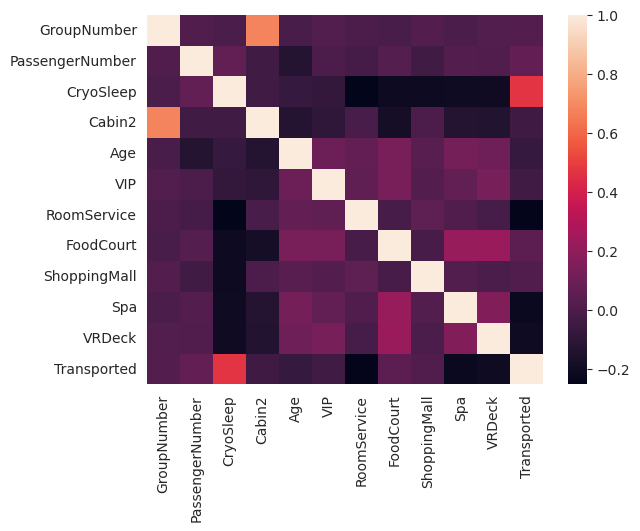

In [69]:
corr_mat = dataset.corr()
sns.heatmap(corr_mat)

Conclusions:
1. Most continuous variables seem to be uncorrelated with each other.
2. All the spending variables, especially the variables 'FoodCourt', 'Spa' and 'VRDeck' seem to be mildly positively correlated with each other. 'Age' is also positively correlated to this group. Might offer the possibility of doing PCA to reduce dimensionality of the problem.
3. The variables 'RoomService', 'Spa' and 'VRDeck' seem to be mildly negatively correlated with the 'Transported' status.
4. There is a significant anticorrelation between the CryoSleep status and spending on 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck'. This makes sense as people with CryoSleep = True do not seem to spend on anything. Just check this with further analysis. this can provide a useful rule for data imputation.
5. The CryoSleep status also seems to significantly correlate with transported status, which is consistent with the previous two observations. CryoSleep = True seems to be a very good approximate predictor of whether Transported = True or not.

### Checking the anticorrelation between the spending features and CryoSleep

The sum of RoomService for passengers in CryoSleep is: 0.0
The sum of FoodCourt for passengers in CryoSleep is: 0.0
The sum of ShoppingMall for passengers in CryoSleep is: 0.0
The sum of Spa for passengers in CryoSleep is: 0.0
The sum of VRDeck for passengers in CryoSleep is: 0.0


array([<AxesSubplot:title={'center':'0.0'}>,
       <AxesSubplot:title={'center':'1.0'}>], dtype=object)

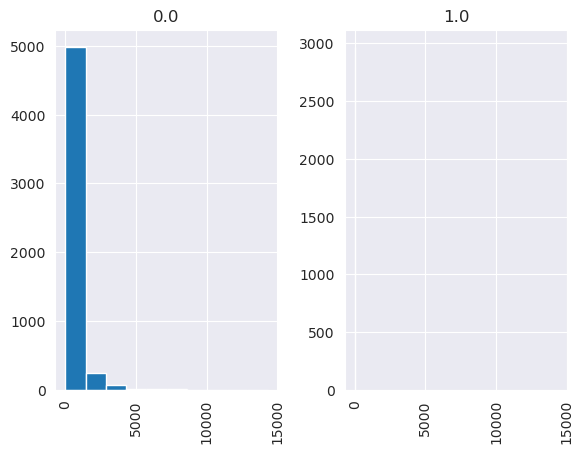

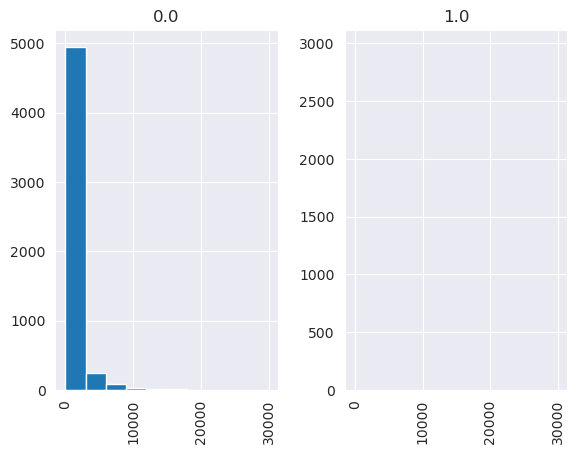

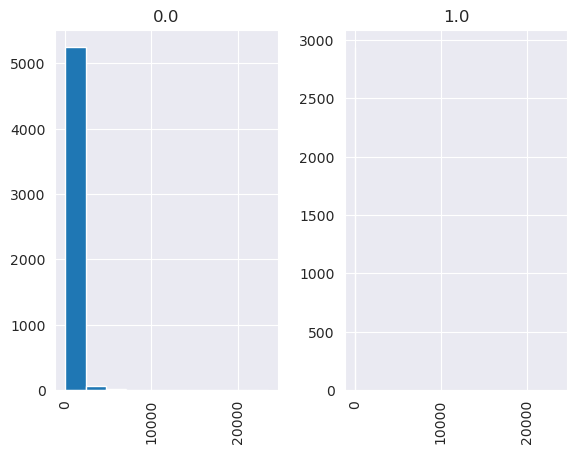

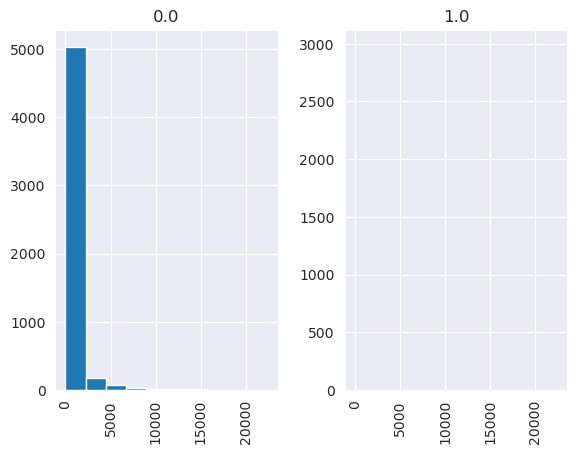

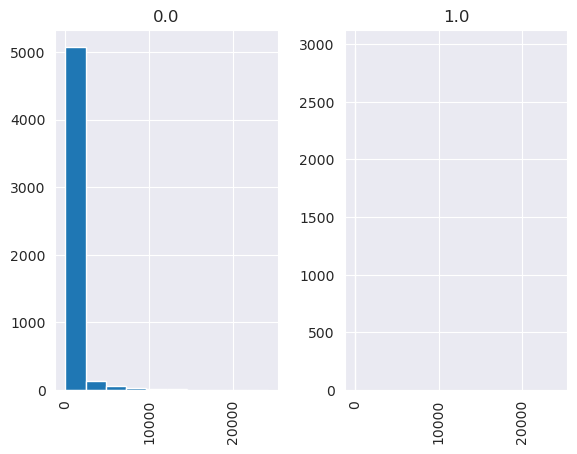

In [70]:
print('The sum of RoomService for passengers in CryoSleep is: ' + str(dataset.loc[dataset['CryoSleep'] == True].RoomService.sum()))
print('The sum of FoodCourt for passengers in CryoSleep is: ' + str(dataset.loc[dataset['CryoSleep'] == True].FoodCourt.sum()))
print('The sum of ShoppingMall for passengers in CryoSleep is: ' + str(dataset.loc[dataset['CryoSleep'] == True].ShoppingMall.sum()))
print('The sum of Spa for passengers in CryoSleep is: ' + str(dataset.loc[dataset['CryoSleep'] == True].Spa.sum()))
print('The sum of VRDeck for passengers in CryoSleep is: ' + str(dataset.loc[dataset['CryoSleep'] == True].VRDeck.sum()))

dataset.loc[dataset['CryoSleep'] == True].FoodCourt.sum()
dataset.loc[dataset['CryoSleep'] == True].ShoppingMall.sum()
dataset.loc[dataset['CryoSleep'] == True].Spa.sum()
dataset.loc[dataset['CryoSleep'] == True].VRDeck.sum()

dataset['RoomService'].hist(by=dataset['CryoSleep'], sharex=True)
dataset['FoodCourt'].hist(by=dataset['CryoSleep'], sharex=True)
dataset['ShoppingMall'].hist(by=dataset['CryoSleep'], sharex=True)
dataset['Spa'].hist(by=dataset['CryoSleep'], sharex=True)
dataset['VRDeck'].hist(by=dataset['CryoSleep'], sharex=True)

### Is there any difference in the distribution of feature values of each feature for the people whose 'Transported' values are True vs False?

array([<AxesSubplot:title={'center':'False'}>,
       <AxesSubplot:title={'center':'True'}>], dtype=object)

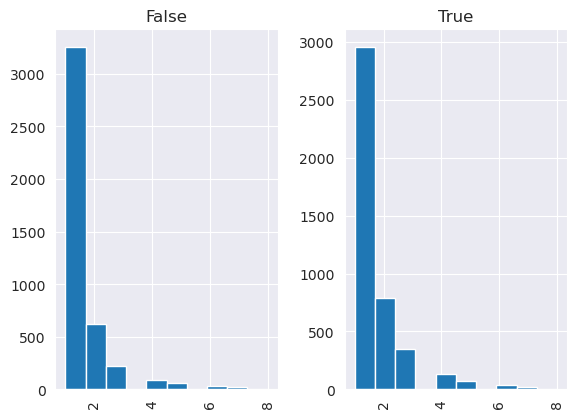

In [71]:
dataset['PassengerNumber'].hist(by=dataset['Transported'], sharex=True)

Conclusion: Which passenger you are in the group doesn't seem to affect the chances of being transported

array([<AxesSubplot:title={'center':'False'}>,
       <AxesSubplot:title={'center':'True'}>], dtype=object)

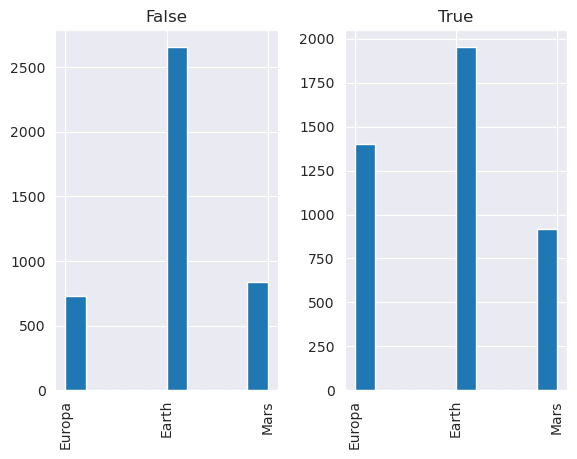

In [72]:
dataset['HomePlanet'].hist(by=dataset['Transported'], sharex=True)

Conclusion: People from Europa or Mars seem more likely to be transported

array([<AxesSubplot:title={'center':'False'}>,
       <AxesSubplot:title={'center':'True'}>], dtype=object)

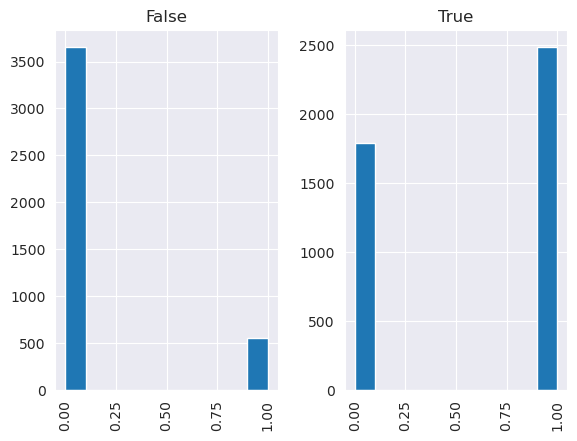

In [73]:
dataset['CryoSleep'].hist(by=dataset['Transported'], sharex=True)

Conclusion: Among the people who were transported, most people were in cryosleep. Among the people who were not transported, most people were not in cryosleep.

array([<AxesSubplot:title={'center':'False'}>,
       <AxesSubplot:title={'center':'True'}>], dtype=object)

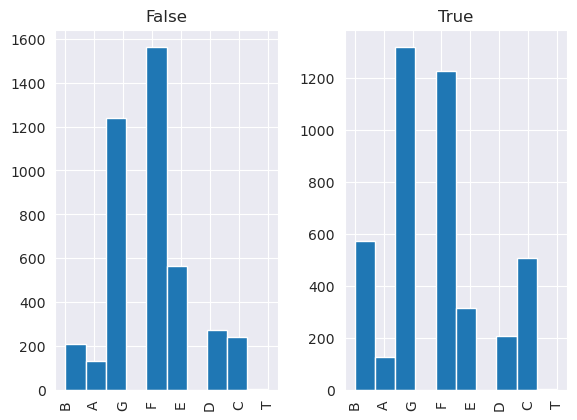

In [53]:
dataset['Cabin1'].hist(by=dataset['Transported'], sharex=True)

Conclusion: The Cabin1 value seems to have some information about transported status. People belonging to cabins B and C seem to be preferentially transported.

array([<AxesSubplot:title={'center':'False'}>,
       <AxesSubplot:title={'center':'True'}>], dtype=object)

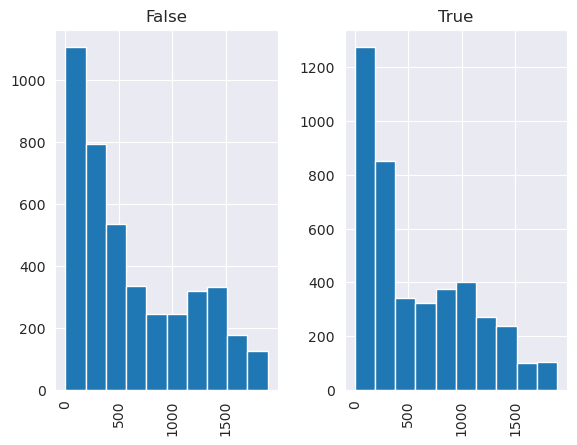

In [74]:
dataset['Cabin2'].hist(by=dataset['Transported'], sharex=True)

Conclusion: There doesn't seem to be much difference in the distribution of the second number of the Cabin upon transporting

array([<AxesSubplot:title={'center':'False'}>,
       <AxesSubplot:title={'center':'True'}>], dtype=object)

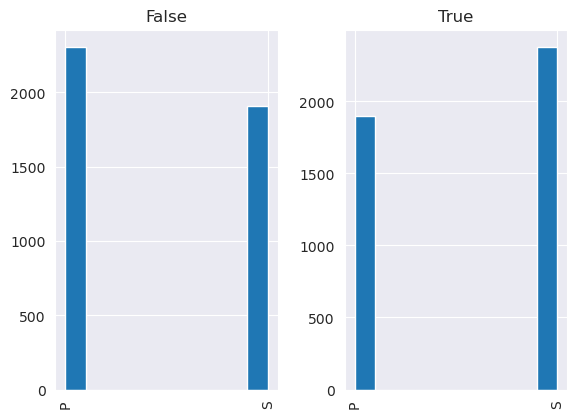

In [54]:
dataset['Cabin3'].hist(by=dataset['Transported'], sharex=True)

Conclusion: The feature Cabin3 seems to contain some information about the transported status. People who were transported were preferentially from S whereas people who were not transported were preferentially from P

array([<AxesSubplot:title={'center':'False'}>,
       <AxesSubplot:title={'center':'True'}>], dtype=object)

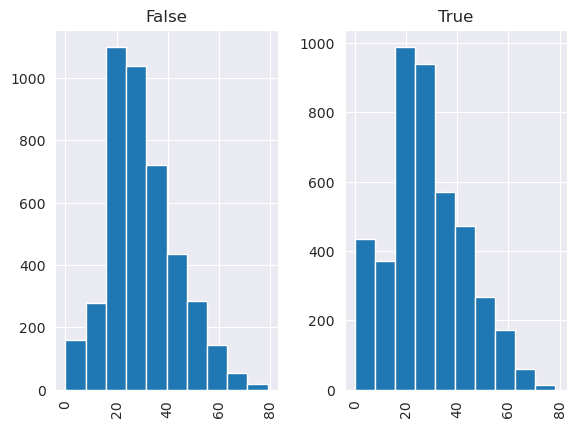

In [75]:
dataset['Age'].hist(by=dataset['Transported'], sharex=True)

Conclusion: There is a slight difference in the age distribution among the people who were transported compared to those who were not. The transported people were younger on average compared to the people who were not transported.

array([<AxesSubplot:title={'center':'False'}>,
       <AxesSubplot:title={'center':'True'}>], dtype=object)

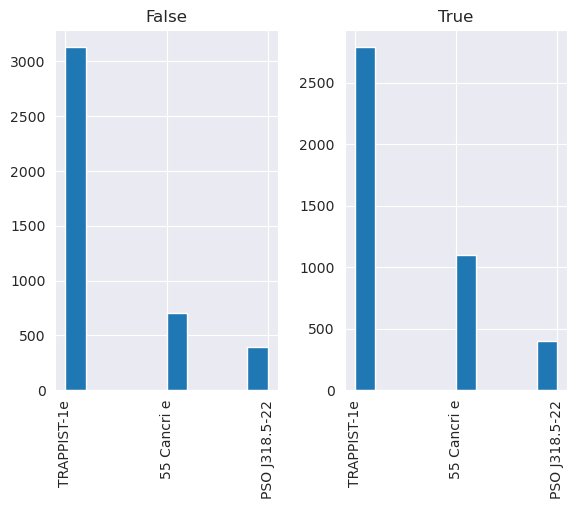

In [76]:
dataset['Destination'].hist(by=dataset['Transported'], sharex=True)

Conclusion: The transported people were more likely to travel to 55 Cancri e and PSO J compared to the non-transported people. If the people were traveling to TRAPPIST-1e, nothing much can be said about their transported status. They same to be the same, and we need to use other features for discrimination.

array([<AxesSubplot:title={'center':'False'}>,
       <AxesSubplot:title={'center':'True'}>], dtype=object)

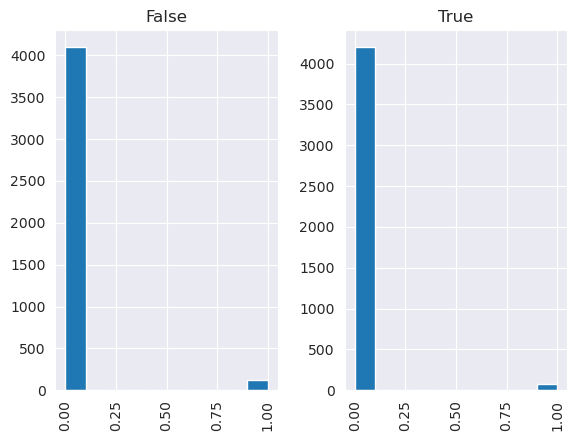

In [77]:
dataset['VIP'].hist(by=dataset['Transported'], sharex=True)

Conclusion: The VIP status doesn't seem to have much to do with the transported status

## Pre-processing the dataset based on exploratory analysis

### Impute the missing data points according to some deterministic rules initially, then later with standard imputation algorithms.

In [69]:
print('In the Training dataset ...')
for (column_name, column_data) in dataset.iteritems():
    print(str(column_name) + ': has ' + str(dataset[column_name].isnull().sum()) + ' NaN values')

In the Training dataset ...
GroupNumber: has 0 NaN values
PassengerNumber: has 0 NaN values
HomePlanet: has 201 NaN values
CryoSleep: has 217 NaN values
Cabin1: has 199 NaN values
Cabin2: has 199 NaN values
Cabin3: has 199 NaN values
Destination: has 182 NaN values
Age: has 179 NaN values
VIP: has 203 NaN values
RoomService: has 181 NaN values
FoodCourt: has 183 NaN values
ShoppingMall: has 208 NaN values
Spa: has 183 NaN values
VRDeck: has 188 NaN values
Name: has 200 NaN values
Transported: has 0 NaN values


In [70]:
print('In the Validation dataset ...')
for (column_name, column_data) in dataset_validation.iteritems():
    print(str(column_name) + ': has ' + str(dataset_validation[column_name].isnull().sum()) + ' NaN values')

In the Validation dataset ...
GroupNumber: has 0 NaN values
PassengerNumber: has 0 NaN values
HomePlanet: has 87 NaN values
CryoSleep: has 93 NaN values
Cabin1: has 100 NaN values
Cabin2: has 100 NaN values
Cabin3: has 100 NaN values
Destination: has 92 NaN values
Age: has 91 NaN values
VIP: has 93 NaN values
RoomService: has 82 NaN values
FoodCourt: has 106 NaN values
ShoppingMall: has 98 NaN values
Spa: has 101 NaN values
VRDeck: has 80 NaN values
Name: has 94 NaN values


In [71]:
def impute_spending_variables(dataset):

    spending_variables = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

    # First set all the NaNs in the spending variables to 0.0 wherever the passengers are in cryosleep
    for svar in spending_variables:
        dataset.loc[pd.isna(dataset[svar]) & dataset['CryoSleep'] == 1.0, svar] = 0.0

    # Then impute all the NaN in the spending variables to 0.0 wherever passengers are not in cryosleep, but their spending in all other categories is 0.0
    for svar in spending_variables:
        for i in range(len(dataset[svar].values)):
            if pd.isna(dataset[svar].iloc[i]):
                sum_of_other_svars = 0.0
                for svar2 in spending_variables:
                    if svar2 != svar and not pd.isna(dataset[svar2].iloc[i]):
                        sum_of_other_svars += dataset[svar2].iloc[i]
                if sum_of_other_svars == 0.0:
                    dataset[svar].iloc[i] = 0.0

    # Then impute all the remaining NaNs to the median values of the column
    for svar in spending_variables:
        dataset.loc[pd.isna(dataset[svar]), svar] = dataset[svar].median()

    for svar in spending_variables:
        print('After this imputation step, the number of NaNs in ' + str(svar) + ' has reduced to ' + str(len(np.where(pd.isna(dataset[svar]) == True)[0])))

    return dataset

dataset = impute_spending_variables(dataset=dataset)
dataset_validation = impute_spending_variables(dataset=dataset_validation)

/home/npradeep96/miniconda3/envs/IDRBlocks/lib/python3.7/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


After this imputation step, the number of NaNs in RoomService has reduced to 0
After this imputation step, the number of NaNs in FoodCourt has reduced to 0
After this imputation step, the number of NaNs in ShoppingMall has reduced to 0
After this imputation step, the number of NaNs in Spa has reduced to 0
After this imputation step, the number of NaNs in VRDeck has reduced to 0
After this imputation step, the number of NaNs in RoomService has reduced to 0
After this imputation step, the number of NaNs in FoodCourt has reduced to 0
After this imputation step, the number of NaNs in ShoppingMall has reduced to 0
After this imputation step, the number of NaNs in Spa has reduced to 0
After this imputation step, the number of NaNs in VRDeck has reduced to 0


In [72]:
def impute_cryosleep(dataset):
    for i in range(len(dataset.CryoSleep.values)):
        # Impute the NaNs in the CryoSleep with False if the sum of values of all the spending variables is non-zero.
        if pd.isna(dataset.CryoSleep.iloc[i]) and dataset['RoomService'].iloc[i] + dataset['FoodCourt'].iloc[i] + dataset['ShoppingMall'].iloc[i] + dataset['Spa'].iloc[i] + dataset['VRDeck'].iloc[i] != 0.0:
            dataset.CryoSleep.iloc[i] = 0.0
        # Impute the NaNs in the CryoSleep with True if the sum of values of all the spending variables is zero. While this is not strictly correct and there may be passengers who are not in sleep but also do not spend, these kind of passengers are small in number.
        elif pd.isna(dataset.CryoSleep.iloc[i]) and dataset['RoomService'].iloc[i] + dataset['FoodCourt'].iloc[i] + dataset['ShoppingMall'].iloc[i] + dataset['Spa'].iloc[i] + dataset['VRDeck'].iloc[i] == 0.0:
            dataset.CryoSleep.iloc[i] = 1.0

    print('After this imputation step, the number of NaNs in CryoSleep has reduced to ' + str(len(np.where(pd.isna(dataset['CryoSleep']) == True)[0])))
    return dataset

dataset = impute_cryosleep(dataset=dataset)
dataset_validation = impute_cryosleep(dataset=dataset_validation)

After this imputation step, the number of NaNs in CryoSleep has reduced to 0
After this imputation step, the number of NaNs in CryoSleep has reduced to 0


In [73]:
# Passengers within the same group number are likely to be from the same home planet, and largely have the same values of Cabin1 and Cabin3 values. We can use this rule to impute some data.
def impute_neighbor_for_same_group_number(dataset):
    for index in range(len(dataset['HomePlanet'].values)):
        if pd.isna(dataset['HomePlanet'].iloc[index]):
            if index != 0 and dataset['GroupNumber'].iloc[index] == dataset['GroupNumber'].iloc[index-1]:
                dataset['HomePlanet'].iloc[index] = dataset['HomePlanet'].iloc[index-1]
            elif index != len(dataset['GroupNumber']) and dataset['GroupNumber'].iloc[index] == dataset['GroupNumber'].iloc[index+1]:
                dataset['HomePlanet'].iloc[index] = dataset['HomePlanet'].iloc[index+1]
        if pd.isna(dataset['Cabin1'].iloc[index]):
            if index != 0 and dataset['GroupNumber'].iloc[index] == dataset['GroupNumber'].iloc[index-1]:
                dataset['Cabin1'].iloc[index] = dataset['Cabin1'].iloc[index-1]
            elif index != len(dataset['GroupNumber']) and dataset['GroupNumber'].iloc[index] == dataset['GroupNumber'].iloc[index+1]:
                dataset['Cabin1'].iloc[index] = dataset['Cabin1'].iloc[index+1]
        if pd.isna(dataset['Cabin3'].iloc[index]):
            if index != 0 and dataset['GroupNumber'].iloc[index] == dataset['GroupNumber'].iloc[index-1]:
                dataset['Cabin3'].iloc[index] = dataset['Cabin3'].iloc[index-1]
            elif index != len(dataset['GroupNumber']) and dataset['GroupNumber'].iloc[index] == dataset['GroupNumber'].iloc[index+1]:
                dataset['Cabin3'].iloc[index] = dataset['Cabin3'].iloc[index+1]


    print('After this imputation step, the number of NaNs in HomePlanet has reduced to ' + str(len(np.where(pd.isna(dataset['HomePlanet']) == True)[0])))
    print('After this imputation step, the number of NaNs in Cabin1 has reduced to ' + str(len(np.where(pd.isna(dataset['Cabin1']) == True)[0])))
    print('After this imputation step, the number of NaNs in Cabin3 has reduced to ' + str(len(np.where(pd.isna(dataset['Cabin3']) == True)[0])))

    return dataset

dataset = impute_neighbor_for_same_group_number(dataset=dataset)
dataset_validation = impute_neighbor_for_same_group_number(dataset=dataset_validation)

After this imputation step, the number of NaNs in HomePlanet has reduced to 111
After this imputation step, the number of NaNs in Cabin1 has reduced to 99
After this imputation step, the number of NaNs in Cabin3 has reduced to 99
After this imputation step, the number of NaNs in HomePlanet has reduced to 46
After this imputation step, the number of NaNs in Cabin1 has reduced to 63
After this imputation step, the number of NaNs in Cabin3 has reduced to 63


In [74]:
# Set the remaining values of HomePlanet, Destination, and VIP status to appropriate values
def impute_to_most_likely_values(dataset):
    dataset.loc[pd.isna(dataset['HomePlanet']), 'HomePlanet'] = 'None' #Treat None as a separate feature type
    dataset.loc[pd.isna(dataset['Destination']), 'Destination'] = 'None' #Treat None as a separate feature type
    dataset.loc[pd.isna(dataset['VIP']), 'VIP'] = 0.0
    dataset.loc[pd.isna(dataset['Age']), 'Age'] = dataset.Age.median()
    dataset.loc[pd.isna(dataset['Cabin1']), 'Cabin1'] = 'None' #Treat None as a separate feature type
    dataset.loc[pd.isna(dataset['Cabin3']), 'Cabin3'] = 'None' #Treat None as a separate feature type

    print('After this imputation step, the number of NaNs in HomePlanet has reduced to ' + str(len(np.where(pd.isna(dataset['HomePlanet']) == True)[0])))
    print('After this imputation step, the number of NaNs in Destination has reduced to ' + str(len(np.where(pd.isna(dataset['Destination']) == True)[0])))
    print('After this imputation step, the number of NaNs in VIP has reduced to ' + str(len(np.where(pd.isna(dataset['VIP']) == True)[0])))
    print('After this imputation step, the number of NaNs in Age has reduced to ' + str(len(np.where(pd.isna(dataset['Age']) == True)[0])))
    print('After this imputation step, the number of NaNs in Cabin1 has reduced to ' + str(len(np.where(pd.isna(dataset['Cabin1']) == True)[0])))
    print('After this imputation step, the number of NaNs in Cabin3 has reduced to ' + str(len(np.where(pd.isna(dataset['Cabin3']) == True)[0])))

    return dataset

dataset = impute_to_most_likely_values(dataset=dataset)
dataset_validation = impute_to_most_likely_values(dataset=dataset_validation)

After this imputation step, the number of NaNs in HomePlanet has reduced to 0
After this imputation step, the number of NaNs in Destination has reduced to 0
After this imputation step, the number of NaNs in VIP has reduced to 0
After this imputation step, the number of NaNs in Age has reduced to 0
After this imputation step, the number of NaNs in Cabin1 has reduced to 0
After this imputation step, the number of NaNs in Cabin3 has reduced to 0
After this imputation step, the number of NaNs in HomePlanet has reduced to 0
After this imputation step, the number of NaNs in Destination has reduced to 0
After this imputation step, the number of NaNs in VIP has reduced to 0
After this imputation step, the number of NaNs in Age has reduced to 0
After this imputation step, the number of NaNs in Cabin1 has reduced to 0
After this imputation step, the number of NaNs in Cabin3 has reduced to 0


In [75]:
# Drop the Cabin number and Name of passengers
dataset = dataset.drop(['Name', 'Cabin2', 'GroupNumber'], axis=1)
dataset_validation = dataset_validation.drop(['Name', 'Cabin2', 'GroupNumber'], axis=1)

In [76]:
dataset.head(50)

,PassengerNumber,HomePlanet,CryoSleep,Cabin1,Cabin3,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported
0,1,Europa,False,B,P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,False
1,1,Earth,False,F,S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,True
2,1,Europa,False,A,S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,False
3,2,Europa,False,A,S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,False
4,1,Earth,False,F,S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,True
5,1,Earth,False,F,P,PSO J318.5-22,44.0,False,0.0,483.0,0.0,291.0,0.0,True
6,1,Earth,False,F,S,TRAPPIST-1e,26.0,False,42.0,1539.0,3.0,0.0,0.0,True
7,2,Earth,True,G,S,TRAPPIST-1e,28.0,False,0.0,0.0,0.0,0.0,0.0,True
8,1,Earth,False,F,S,TRAPPIST-1e,35.0,False,0.0,785.0,17.0,216.0,0.0,True
9,1,Europa,True,B,P,55 Cancri e,14.0,False,0.0,0.0,0.0,0.0,0.0,True


In [155]:
dataset_validation.head(5)

,HomePlanet,CryoSleep,Cabin1,Cabin3,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
0,Earth,1.0,G,S,TRAPPIST-1e,27.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Earth,1.0,F,S,TRAPPIST-1e,19.0,0.0,0.0,9.0,0.0,2823.0,0.0
2,Europa,1.0,C,S,55 Cancri e,31.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Europa,1.0,C,S,TRAPPIST-1e,38.0,0.0,0.0,6652.0,0.0,181.0,585.0
4,Earth,1.0,F,S,TRAPPIST-1e,20.0,0.0,10.0,0.0,635.0,0.0,0.0


In [156]:
# Ensure that the data columns with categorical values are converted to int
def convert_string_to_categorical(dataset):
    home_planets = dataset.HomePlanet.unique()
    for i in range(len(home_planets)):
        dataset.loc[dataset['HomePlanet'] == home_planets[i], 'HomePlanet'] = float(i)
    destinations = dataset.Destination.unique()
    for i in range(len(destinations)):
        dataset.loc[dataset['Destination'] == destinations[i], 'Destination'] = float(i)
    cabin1 = dataset['Cabin1'].unique()
    for i in range(len(cabin1)):
        dataset.loc[dataset['Cabin1'] == cabin1[i], 'Cabin1'] = float(i)
    cabin3 = dataset['Cabin3'].unique()
    for i in range(len(cabin3)):
        dataset.loc[dataset['Cabin3'] == cabin3[i], 'Cabin3'] = float(i)

    dataset['HomePlanet'] = dataset.HomePlanet.astype('float')
    dataset['Destination'] = dataset.Destination.astype('float')
    dataset['Cabin1'] = dataset.Cabin1.astype('float')
    dataset['Cabin3'] = dataset.Cabin3.astype('float')

    return dataset

dataset = convert_string_to_categorical(dataset=dataset)
dataset_validation = convert_string_to_categorical(dataset=dataset_validation)

In [79]:
categorical_cols = ['PassengerNumber', 'HomePlanet', 'CryoSleep','Cabin1', 'Cabin3', 'Destination', 'VIP']
onehotencoder = OneHotEncoder(drop='first')
onehotencoder.fit(dataset[categorical_cols])
transformed_data = onehotencoder.transform(dataset[categorical_cols]).toarray()

# print(transformed_data)
# print(dataset)
# the above transformed_data is an array so convert it to dataframe
encoded_data = pd.DataFrame(data=transformed_data, index=dataset.index)
encoded_data.columns = onehotencoder.get_feature_names(categorical_cols)
# decoded_data = onehotencoder.inverse_transform(encoded_data)
# print(encoded_data)
# encoded_data.head(5)
# print(decoded_data)
#
# now concatenate the original data and the encoded data using pandas
concatenated_data = pd.concat([encoded_data, dataset], axis=1)
concatenated_data.head(50)

,PassengerNumber_2,PassengerNumber_3,PassengerNumber_4,PassengerNumber_5,PassengerNumber_6,PassengerNumber_7,PassengerNumber_8,HomePlanet_Europa,HomePlanet_Mars,HomePlanet_None,...,Cabin3,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,False
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,True
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,False
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,False
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,True
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,P,PSO J318.5-22,44.0,False,0.0,483.0,0.0,291.0,0.0,True
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,S,TRAPPIST-1e,26.0,False,42.0,1539.0,3.0,0.0,0.0,True
7,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,S,TRAPPIST-1e,28.0,False,0.0,0.0,0.0,0.0,0.0,True
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,S,TRAPPIST-1e,35.0,False,0.0,785.0,17.0,216.0,0.0,True
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,P,55 Cancri e,14.0,False,0.0,0.0,0.0,0.0,0.0,True


In [82]:
categorical_cols = ['PassengerNumber', 'HomePlanet', 'CryoSleep','Cabin1', 'Cabin3', 'Destination', 'VIP']
onehotencoder = OneHotEncoder(drop='first')
onehotencoder.fit(dataset_validation[categorical_cols])
transformed_data = onehotencoder.transform(dataset_validation[categorical_cols]).toarray()

# print(transformed_data)
# print(dataset)
# the above transformed_data is an array so convert it to dataframe
encoded_data = pd.DataFrame(data=transformed_data, index=dataset_validation.index)
encoded_data.columns = onehotencoder.get_feature_names(categorical_cols)
# decoded_data = onehotencoder.inverse_transform(encoded_data)
# print(encoded_data)
# encoded_data.head(5)
# print(decoded_data)
#
# now concatenate the original data and the encoded data using pandas
concatenated_data = pd.concat([encoded_data, dataset_validation.drop(categorical_cols)], axis=1)
concatenated_data.head(50)

KeyError: "['PassengerNumber' 'HomePlanet' 'CryoSleep' 'Cabin1' 'Cabin3'\n 'Destination' 'VIP'] not found in axis"

In [158]:
# Checking that we do not have any more NaNs
print('In the Training data ...')
for (column_name, column_data) in dataset.iteritems():
    print(str(column_name) + ': has ' + str(dataset[column_name].isnull().sum()) + ' NaN values')
print('In the Validation data ...')
for (column_name, column_data) in dataset_validation.iteritems():
    print(str(column_name) + ': has ' + str(dataset_validation[column_name].isnull().sum()) + ' NaN values')

In the Training data ...
HomePlanet: has 0 NaN values
CryoSleep: has 0 NaN values
Cabin1: has 0 NaN values
Cabin3: has 0 NaN values
Destination: has 0 NaN values
Age: has 0 NaN values
VIP: has 0 NaN values
RoomService: has 0 NaN values
FoodCourt: has 0 NaN values
ShoppingMall: has 0 NaN values
Spa: has 0 NaN values
VRDeck: has 0 NaN values
Transported: has 0 NaN values
In the Validation data ...
HomePlanet: has 0 NaN values
CryoSleep: has 0 NaN values
Cabin1: has 0 NaN values
Cabin3: has 0 NaN values
Destination: has 0 NaN values
Age: has 0 NaN values
VIP: has 0 NaN values
RoomService: has 0 NaN values
FoodCourt: has 0 NaN values
ShoppingMall: has 0 NaN values
Spa: has 0 NaN values
VRDeck: has 0 NaN values


## Trying different machine learning algorithms for classification

Attempt 1: The individual features themselves look informative to predict the transported state based on preliminary analysis as the distribution of the feature values looks different for the two different classes. Given this, I am going to attempt tree based models first. Among tree based models, I am thinking of first attempting to use a boosted tree as that prevents overfitting that is typical to tree based models by using an ensemble of weak classifiers.

In [159]:
import xgboost as xgb
# from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix)
from sklearn.model_selection import GridSearchCV

In [ ]:
X_train = dataset.iloc[:, :-1]
Y_train = dataset.Transported

xgb_model = xgb.XGBClassifier(objective="binary:logistic", random_state=42)

### Impact of learning rate

In [161]:
params = {"learning_rate": [0.03, 0.1, 0.3]}

search = GridSearchCV(xgb_model, param_grid=params, verbose=1, return_train_score=True, n_jobs=1)

search.fit(X_train, Y_train)

def report_best_scores(results, n_top=5):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

report_best_scores(search.cv_results_, 3)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
Model with rank: 1
Mean validation score: 0.799 (std: 0.012)
Parameters: {'learning_rate': 0.1}

Model with rank: 2
Mean validation score: 0.795 (std: 0.010)
Parameters: {'learning_rate': 0.03}

Model with rank: 3
Mean validation score: 0.788 (std: 0.015)
Parameters: {'learning_rate': 0.3}



### Impact of max_depth

In [162]:
params = {"max_depth": [2, 4, 6]}

search = GridSearchCV(xgb_model, param_grid=params, verbose=1, return_train_score=True, n_jobs=1)

search.fit(X_train, Y_train)

def report_best_scores(results, n_top=5):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

report_best_scores(search.cv_results_, 3)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
Model with rank: 1
Mean validation score: 0.796 (std: 0.012)
Parameters: {'max_depth': 4}

Model with rank: 2
Mean validation score: 0.793 (std: 0.006)
Parameters: {'max_depth': 2}

Model with rank: 3
Mean validation score: 0.788 (std: 0.015)
Parameters: {'max_depth': 6}



### Impact of number of estimators used

In [163]:
params = {"n_estimators": [100, 150, 200]}

search = GridSearchCV(xgb_model, param_grid=params, verbose=1, return_train_score=True, n_jobs=1)

search.fit(X_train, Y_train)

def report_best_scores(results, n_top=5):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

report_best_scores(search.cv_results_, 3)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
Model with rank: 1
Mean validation score: 0.788 (std: 0.015)
Parameters: {'n_estimators': 100}

Model with rank: 2
Mean validation score: 0.787 (std: 0.015)
Parameters: {'n_estimators': 150}

Model with rank: 3
Mean validation score: 0.785 (std: 0.015)
Parameters: {'n_estimators': 200}



In [91]:
d = pd.read_csv('train_cleaned.csv')
d.head(100)

,PassengerId,HomePlanet_Europa,HomePlanet_Mars,CryoSleep_True,Cabin1_B,Cabin1_C,Cabin1_D,Cabin1_E,Cabin1_F,Cabin1_G,...,Destination_TRAPPIST-1e,VIP_True,PassengerNumber,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported
0,0001_01,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1,39.0,0.0,0.0,0.0,0.0,0.0,False
1,0002_01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,1,24.0,109.0,9.0,25.0,549.0,44.0,True
2,0003_01,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1,58.0,43.0,3576.0,0.0,6715.0,49.0,False
3,0003_02,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,2,33.0,0.0,1283.0,371.0,3329.0,193.0,False
4,0004_01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,1,16.0,303.0,70.0,151.0,565.0,2.0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0103_01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,1,24.0,0.0,0.0,0.0,0.0,17.0,True
96,0103_02,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,2,9.0,0.0,0.0,0.0,0.0,0.0,True
97,0103_03,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,3,6.0,0.0,0.0,0.0,0.0,0.0,False
98,0105_01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,1,27.0,0.0,0.0,570.0,2.0,131.0,False


In [89]:
d = pd.read_csv('test_cleaned.csv')
d.head(100)

,PassengerId,HomePlanet_Europa,HomePlanet_Mars,CryoSleep_True,Cabin1_B,Cabin1_C,Cabin1_D,Cabin1_E,Cabin1_F,Cabin1_G,...,Destination_PSO J318.5-22,Destination_TRAPPIST-1e,VIP_True,PassengerNumber,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
0,0013_01,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,1,27.0,0.0,0.0,0.0,0.0,0.0
1,0018_01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,1,19.0,0.0,9.0,0.0,2823.0,0.0
2,0019_01,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1,31.0,0.0,0.0,0.0,0.0,0.0
3,0021_01,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1,38.0,0.0,6652.0,0.0,181.0,585.0
4,0023_01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,1,20.0,10.0,0.0,635.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0214_02,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,2,42.0,4762.0,20.0,0.0,4.0,41.0
96,0215_01,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,1,23.0,0.0,0.0,0.0,0.0,0.0
97,0218_01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,1,19.0,741.0,12.0,1.0,0.0,0.0
98,0226_01,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1,25.0,3.0,3833.0,8098.0,1531.0,0.0


<AxesSubplot:>

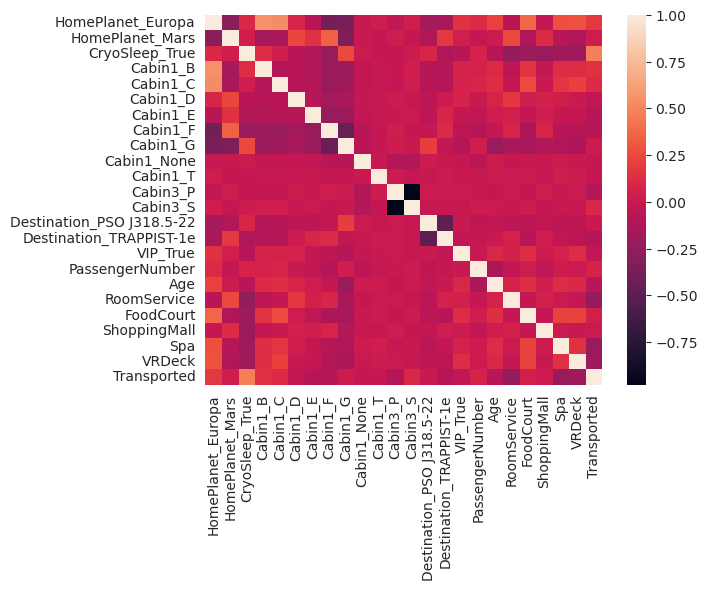

In [92]:
corr_mat = d.corr()
sns.heatmap(corr_mat)

In [99]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Center the data
scaler = StandardScaler(with_mean=True, with_std=False)
centered_matrix = scaler.fit_transform(d.iloc[:, 1:-1])

nums = np.arange(len(d.columns))

for num in nums:
  pca = PCA(n_components=num)
  mat = pca.fit_transform(centered_matrix)
  mat.head(10)
  print(np.sum(pca.explained_variance_ratio_))

AttributeError: 'numpy.ndarray' object has no attribute 'head'